Contains the R models used to analyze the number of review comments before and after the introduction of Travis CI. Looks at whether a boolean variable `IsAfterTravisIntroduction` can be used to predict the number of review comments under a pull request. 

In [26]:
filename <- 'generated/num_of_review_comments.csv'

NumOfReviewCommentsData <- read.csv(file=filename, header=TRUE, sep=",")

summary(NumOfReviewCommentsData)

#NumOfReviewCommentsData = NumOfReviewCommentsData[NumOfReviewCommentsData$ReviewComments < quantile(NumOfReviewCommentsData$ReviewComments, 0.99), ]
#NumOfReviewCommentsData = NumOfReviewCommentsData[NumOfReviewCommentsData$GeneralComments < quantile(NumOfReviewCommentsData$GeneralComments, 0.99), ]

summary(NumOfReviewCommentsData)

 ReviewComments    ShareReviewComments GeneralComments  
 Min.   :  0.000   Min.   :  0.00      Min.   :  0.000  
 1st Qu.:  0.000   1st Qu.:  0.00      1st Qu.:  0.000  
 Median :  0.000   Median :  0.00      Median :  1.000  
 Mean   :  1.697   Mean   : 13.05      Mean   :  2.712  
 3rd Qu.:  0.000   3rd Qu.:  0.00      3rd Qu.:  3.000  
 Max.   :404.000   Max.   :100.00      Max.   :461.000  
                                                        
 GeneralCommentsDiscussingBuild   Additions         Deletions        
 Min.   :0                      Min.   :      0   Min.   :      0.0  
 1st Qu.:0                      1st Qu.:      1   1st Qu.:      0.0  
 Median :0                      Median :      9   Median :      2.0  
 Mean   :0                      Mean   :   2941   Mean   :    637.6  
 3rd Qu.:0                      3rd Qu.:     70   3rd Qu.:     19.0  
 Max.   :0                      Max.   :4146796   Max.   :1186576.0  
                                                      

 ReviewComments    ShareReviewComments GeneralComments  
 Min.   :  0.000   Min.   :  0.00      Min.   :  0.000  
 1st Qu.:  0.000   1st Qu.:  0.00      1st Qu.:  0.000  
 Median :  0.000   Median :  0.00      Median :  1.000  
 Mean   :  1.697   Mean   : 13.05      Mean   :  2.712  
 3rd Qu.:  0.000   3rd Qu.:  0.00      3rd Qu.:  3.000  
 Max.   :404.000   Max.   :100.00      Max.   :461.000  
                                                        
 GeneralCommentsDiscussingBuild   Additions         Deletions        
 Min.   :0                      Min.   :      0   Min.   :      0.0  
 1st Qu.:0                      1st Qu.:      1   1st Qu.:      0.0  
 Median :0                      Median :      9   Median :      2.0  
 Mean   :0                      Mean   :   2941   Mean   :    637.6  
 3rd Qu.:0                      3rd Qu.:     70   3rd Qu.:     19.0  
 Max.   :0                      Max.   :4146796   Max.   :1186576.0  
                                                      

In [27]:
library(lmerTest)
library(MuMIn)
library(VIF)
library(sqldf)

vif.mer <- function (fit) {
    ## adapted from rms::vif
    
    v <- vcov(fit)
    nam <- names(fixef(fit))

    ## exclude intercepts
    ns <- sum(1 * (nam == "Intercept" | nam == "(Intercept)"))
    if (ns > 0) {
        v <- v[-(1:ns), -(1:ns), drop = FALSE]
        nam <- nam[-(1:ns)]
    }
    
    d <- diag(v)^0.5
    v <- diag(solve(v/(d %o% d)))
    names(v) <- nam
    v
}

In [28]:
hasReviewComments <- sqldf("select *
                      from 'NumOfReviewCommentsData' 
                      where ReviewComments > 0")

hasGeneralComments <- sqldf("select *
                      from 'NumOfReviewCommentsData' 
                      where GeneralComments > 0")

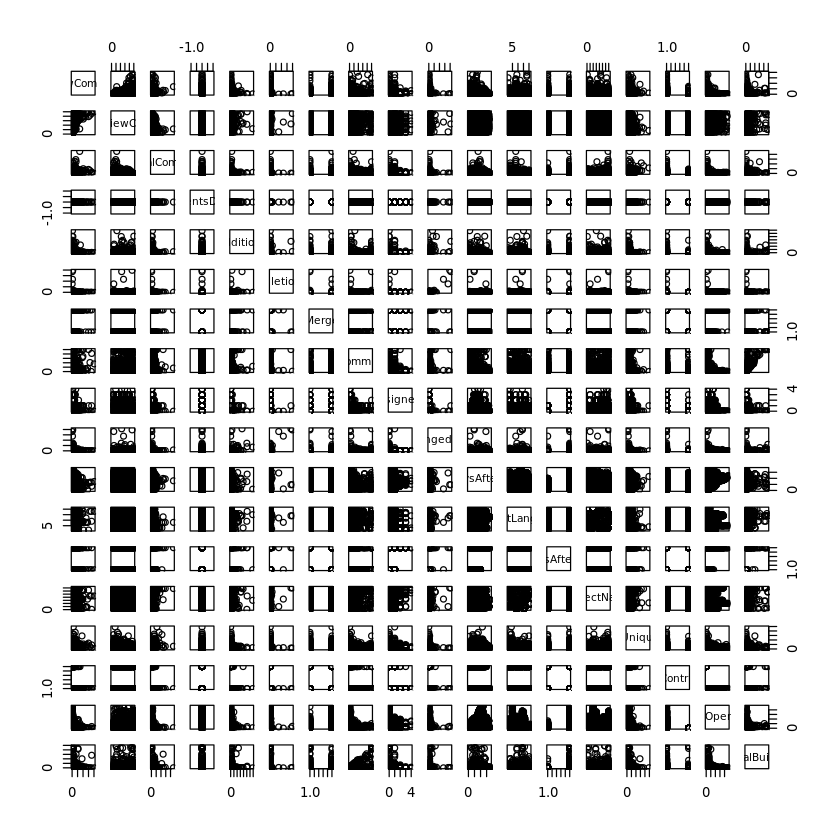

In [22]:
plot(hasReviewComments)

In [29]:
modelNumberReviewComments = lmer(log(ReviewComments) ~ 
            log(Additions + 1) +
            log(Deletions + 1) +
            IsMerged +
            log(Commits + 1) +
            log(Assignees + 1) + 
            log(ChangedFiles + 1) + 
            log(NumOfUniqueUsers + 1) +    
            log(PRsOpened + 1) +
            log(TotalBuilds + 1) +
            NewContributor + 
            #log(PrOpenedDaysAfterProjectStart + 1) +
            IsAfter + 
            (1|ProjectLanguage) +
            (1|ProjectName),
          data= hasReviewComments, 
          REML=FALSE)
summary(modelNumberReviewComments)
r.squaredGLMM(modelNumberReviewComments)
vif.mer(modelNumberReviewComments)
anova(modelNumberReviewComments)

Linear mixed model fit by maximum likelihood t-tests use Satterthwaite
  approximations to degrees of freedom [lmerMod]
Formula: log(ReviewComments) ~ log(Additions + 1) + log(Deletions + 1) +  
    IsMerged + log(Commits + 1) + log(Assignees + 1) + log(ChangedFiles +  
    1) + log(NumOfUniqueUsers + 1) + log(PRsOpened + 1) + log(TotalBuilds +  
    1) + NewContributor + IsAfter + (1 | ProjectLanguage) + (1 |  
    ProjectName)
   Data: hasReviewComments

     AIC      BIC   logLik deviance df.resid 
 45741.9  45858.8 -22856.0  45711.9    17821 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8395 -0.6801 -0.0419  0.6525  5.0268 

Random effects:
 Groups          Name        Variance Std.Dev.
 ProjectName     (Intercept) 0.049004 0.22137 
 ProjectLanguage (Intercept) 0.004757 0.06897 
 Residual                    0.753327 0.86794 
Number of obs: 17836, groups:  ProjectName, 62; ProjectLanguage, 19

Fixed effects:
                            Estimate Std. Error         

R2m       R2c 
0.2872438 0.3347217

log(Additions + 1)        log(Deletions + 1)              IsMergedTrue 
                 3.019385                  2.318548                  1.058567 
         log(Commits + 1)        log(Assignees + 1)     log(ChangedFiles + 1) 
                 1.584304                  1.010096                  3.471124 
log(NumOfUniqueUsers + 1)        log(PRsOpened + 1)      log(TotalBuilds + 1) 
                 1.091050                  1.577266                  2.663358 
       NewContributorTrue               IsAfterTrue 
                 1.376688                  2.650408

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
log(Additions + 1),4.294549e+02,4.294549e+02,1,17788.76,5.700775e+02,0.000000e+00
log(Deletions + 1),2.070938e+00,2.070938e+00,1,17826.28,2.749054e+00,9.732956e-02
IsMerged,2.110702e+01,2.110702e+01,1,17833.51,2.801839e+01,1.215905e-07
log(Commits + 1),3.128900e+02,3.128900e+02,1,17827.24,4.153441e+02,0.000000e+00
log(Assignees + 1),5.862935e+01,5.862935e+01,1,17517.74,7.782720e+01,0.000000e+00
log(ChangedFiles + 1),2.302867e+01,2.302867e+01,1,17810.99,3.056928e+01,3.266795e-08
log(NumOfUniqueUsers + 1),2.007180e+03,2.007180e+03,1,17309.10,2.664420e+03,0.000000e+00
log(PRsOpened + 1),4.766275e+01,4.766275e+01,1,17649.30,6.326964e+01,1.776357e-15
log(TotalBuilds + 1),6.771453e+00,6.771453e+00,1,17832.99,8.988727e+00,2.720245e-03
NewContributor,1.251932e+01,1.251932e+01,1,17832.40,1.661870e+01,4.589626e-05


In [21]:
modelNumberReviewComments = lmer(log(GeneralComments) ~ 
            log(Additions + 1) +
            log(Deletions + 1) +
            IsMerged +
            log(Commits + 1) +
            log(Assignees + 1) + 
            log(ChangedFiles + 1) + 
            log(NumOfUniqueUsers + 1) +    
            log(PRsOpened + 1) +
            log(TotalBuilds + 1) +
            NewContributor + 
            #log(PrOpenedDaysAfterProjectStart + 1) +
            IsAfter + 
            (1|ProjectLanguage) +
            (1|ProjectName),
          data= hasGeneralComments, 
          REML=FALSE)
summary(modelNumberReviewComments)
r.squaredGLMM(modelNumberReviewComments)
vif.mer(modelNumberReviewComments)
anova(modelNumberReviewComments)

Linear mixed model fit by maximum likelihood t-tests use Satterthwaite
  approximations to degrees of freedom [lmerMod]
Formula: log(GeneralComments) ~ log(Additions + 1) + log(Deletions + 1) +  
    IsMerged + log(Commits + 1) + log(Assignees + 1) + log(ChangedFiles +  
    1) + log(NumOfUniqueUsers + 1) + log(PRsOpened + 1) + log(TotalBuilds +  
    1) + NewContributor + IsAfter + (1 | ProjectLanguage) + (1 +  
    IsAfter | ProjectName)
   Data: hasGeneralComments

     AIC      BIC   logLik deviance df.resid 
 96246.4  96402.6 -48106.2  96212.4    72352 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.7591 -0.4839 -0.0663  0.4306  7.7451 

Random effects:
 Groups          Name        Variance  Std.Dev.  Corr 
 ProjectName     (Intercept) 1.915e-02 1.384e-01      
                 IsAfterTrue 1.116e-02 1.057e-01 -0.03
 ProjectLanguage (Intercept) 2.537e-12 1.593e-06      
 Residual                    2.199e-01 4.689e-01      
Number of obs: 72369, groups:  ProjectNam

R2m       R2c 
0.6747296 0.7072530

log(Additions + 1)        log(Deletions + 1)              IsMergedTrue 
                 2.963155                  2.498149                  1.059918 
         log(Commits + 1)        log(Assignees + 1)     log(ChangedFiles + 1) 
                 1.702042                  1.011306                  3.400308 
log(NumOfUniqueUsers + 1)        log(PRsOpened + 1)      log(TotalBuilds + 1) 
                 1.110293                  1.545859                  1.421804 
       NewContributorTrue               IsAfterTrue 
                 1.460993                  1.113831

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
log(Additions + 1),2.541378e+00,2.541378e+00,1,72338.80087,1.155702e+01,0.0006753043
log(Deletions + 1),1.654369e+00,1.654369e+00,1,72314.44129,7.523310e+00,0.0060920670
IsMerged,4.114458e+01,4.114458e+01,1,72089.23799,1.871066e+02,0.0000000000
log(Commits + 1),8.014806e+01,8.014806e+01,1,72178.65315,3.644765e+02,0.0000000000
log(Assignees + 1),7.261281e+01,7.261281e+01,1,69796.58957,3.302096e+02,0.0000000000
log(ChangedFiles + 1),1.440391e-01,1.440391e-01,1,72339.66211,6.550236e-01,0.4183249951
log(NumOfUniqueUsers + 1),2.686559e+04,2.686559e+04,1,72292.70816,1.221723e+05,0.0000000000
log(PRsOpened + 1),1.573960e+01,1.573960e+01,1,71894.84611,7.157646e+01,0.0000000000
log(TotalBuilds + 1),1.031133e+00,1.031133e+00,1,71243.21405,4.689118e+00,0.0303575389
NewContributor,3.158829e-01,3.158829e-01,1,72275.63675,1.436490e+00,0.2307121412


In [23]:
modelShareReviewComments = lmer(log(ShareReviewComments + 1) ~ 
            log(Additions + 1) +
            log(Deletions + 1) +
            IsMerged +
            log(Commits + 1) +
            log(Assignees + 1) + 
            log(ChangedFiles + 1) +             
            log(NumOfUniqueUsers + 1) +    
            log(PRsOpened + 1) +
            log(TotalBuilds + 1) +
            NewContributor + 
            IsAfter + 
            (1|ProjectLanguage) +
            (1|ProjectName),
          data= NumOfReviewCommentsData, 
          REML=FALSE)
summary(modelShareReviewComments)
r.squaredGLMM(modelShareReviewComments)
vif.mer(modelShareReviewComments)
anova(modelShareReviewComments)

Linear mixed model fit by maximum likelihood t-tests use Satterthwaite
  approximations to degrees of freedom [lmerMod]
Formula: log(ShareReviewComments + 1) ~ log(Additions + 1) + log(Deletions +  
    1) + IsMerged + log(Commits + 1) + log(Assignees + 1) + log(ChangedFiles +  
    1) + log(NumOfUniqueUsers + 1) + log(PRsOpened + 1) + log(TotalBuilds +  
    1) + NewContributor + IsAfter + (1 | ProjectLanguage) + (1 |  
    ProjectName)
   Data: NumOfReviewCommentsData

      AIC       BIC    logLik  deviance  df.resid 
 354760.7  354903.7 -177365.3  354730.7    102225 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3410 -0.7078 -0.1773  0.4411  3.8478 

Random effects:
 Groups          Name        Variance Std.Dev.
 ProjectName     (Intercept) 0.1363   0.3692  
 ProjectLanguage (Intercept) 0.0000   0.0000  
 Residual                    1.8752   1.3694  
Number of obs: 102240, groups:  ProjectName, 72; ProjectLanguage, 21

Fixed effects:
                            Es

R2m       R2c 
0.2838341 0.3323636

log(Additions + 1)        log(Deletions + 1)              IsMergedTrue 
                 3.112252                  2.618796                  1.093121 
         log(Commits + 1)        log(Assignees + 1)     log(ChangedFiles + 1) 
                 1.743349                  1.015604                  3.568340 
log(NumOfUniqueUsers + 1)        log(PRsOpened + 1)      log(TotalBuilds + 1) 
                 1.113858                  1.646165                  2.607842 
       NewContributorTrue               IsAfterTrue 
                 1.448486                  2.453888

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
log(Additions + 1),3775.054246,3775.054246,1,102239.9,2013.120195,0.0000000000
log(Deletions + 1),23.758816,23.758816,1,102205.6,12.669845,0.0003717687
IsMerged,2600.989371,2600.989371,1,102239.9,1387.027547,0.0000000000
log(Commits + 1),2494.440785,2494.440785,1,102233.3,1330.208467,0.0000000000
log(Assignees + 1),254.531686,254.531686,1,101333.6,135.733911,0.0000000000
log(ChangedFiles + 1),1100.472367,1100.472367,1,102230.3,586.848029,0.0000000000
log(NumOfUniqueUsers + 1),43113.485763,43113.485763,1,102095.4,22991.094489,0.0000000000
log(PRsOpened + 1),3.648132,3.648132,1,101929.6,1.945436,0.1630825178
log(TotalBuilds + 1),230.396806,230.396806,1,102217.6,122.863523,0.0000000000
NewContributor,171.211633,171.211633,1,102235.7,91.301892,0.0000000000


In [6]:
modelNumberReviewComments = lmer(log(GeneralCommentsDiscussingBuild + 1) ~ 
            log(Additions + 1) +
            log(Deletions + 1) +
            IsMerged +
            log(Commits + 1) +
            log(Assignees + 1) + 
            log(ChangedFiles + 1) + 
            log(PrOpenedDaysAfterProjectStart + 1) +
            IsAfter + 
            (1|ProjectLanguage) +
            (1|ProjectName),
          data= hasGeneralComments, 
          REML=FALSE)
summary(modelNumberReviewComments)
r.squaredGLMM(modelNumberReviewComments)
vif.mer(modelNumberReviewComments)
anova(modelNumberReviewComments)

Warning message in vcov.merMod(object, use.hessian = use.hessian):
“Computed variance-covariance matrix problem: not a positive definite matrix;
returning NA matrix”

ERROR: Error in asMethod(object): not a positive definite matrix


In [8]:
require(randomForest)



Loading required package: randomForest
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:MuMIn’:

    importance



In [19]:
rfReviewComments=randomForest(log(ReviewComments + 1)  ~ 
            Additions +
            Deletions + 1  +
            IsMerged +
            Commits +
            Assignees  + 
            ChangedFiles + 
            NumOfUniqueUsers + 
            NewContributor +
            PRsOpened +
            TotalBuilds +
            #log(PrOpenedDaysAfterProjectStart + 1) +
            IsAfter,
                data = hasReviewComments)
rfReviewComments


Call:
 randomForest(formula = log(ReviewComments + 1) ~ Additions +      Deletions + 1 + IsMerged + Commits + Assignees + ChangedFiles +      NumOfUniqueUsers + NewContributor + PRsOpened + TotalBuilds +      IsAfter, data = hasReviewComments) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 3

          Mean of squared residuals: 0.4578955
                    % Var explained: 35.08